In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from datetime import datetime
from pathlib import Path
from collections import Counter

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import dill
import pandas as pd
import polars as pl
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import GroupKFold

import lightgbm as lgb

import pytorch_lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from tasks.data.dataset.mappers import EntityEncoder
from tasks.jobs import Splitter

In [55]:
from otto_utils import *
from otto_features import *
from otto_candidates_covisit import *
from otto_lgbm_utils import *

# Load data

## valid

In [4]:
# load
val_df_train = pl.read_parquet(VALIDATION_PATH / "train.parquet", use_pyarrow=True)
val_df_valid_input = pl.read_parquet(VALIDATION_PATH / "valid.parquet", use_pyarrow=True)
val_df_valid_targets = pl.read_parquet(VALIDATION_PATH / "test_labels.parquet", use_pyarrow=True)

## test

In [ ]:
df_train = pl.read_parquet(TRAIN_PROCESSED, use_pyarrow=True)
df_test = pl.read_parquet(TEST_PROCESSED, use_pyarrow=True)

# Features

## valid

### user features

In [66]:
df = val_df_valid_input.unique().sort(["session", "ts"])

In [59]:
df_user_action_stats_features = user_action_stats_features(df)
df_user_time_distr_features = user_time_distr_features(df)

2022-08-22 00:00:00.192000
2022-08-28 21:59:58.621000


In [67]:
df_user_last_type_actions = (
    df
    .groupby(["session", "type"])
    .agg([
        pl.last("aid")
    ])
    .pivot(values="aid", index="session", columns="type")
    .rename({
        "0": "last_click_aid",
        "1": "last_cart_aid",
        "2": "last_order_aid",
    })
    .sort("session")
)

### user item features

In [ ]:
df = val_df_valid_input.unique().sort(["session", "ts"])

In [74]:
df_user_item_history_features = user_item_history_features(df)

### item features

In [62]:
df = pl.concat([val_df_train, val_df_valid_input]).unique().sort(["session", "ts"])

In [63]:
df_item_action_stats_features = item_action_stats_features(df)
df_item_time_distr_features = item_time_distr_features(df)

2022-07-31 22:00:00.025000
2022-08-28 21:59:58.621000


In [64]:
df_item_n_sess_multiple_action = item_n_sessions_with_repeated_actions(df)

In [65]:
df_item_n_sess_multiple_action

aid,item_n_sess_multi_clicks,item_n_sess_multi_carts,item_n_sess_multi_buys
i64,u32,u32,u32
1545088,0,0,0
381056,24,1,0
208448,1,0,0
1041728,1,0,0
625920,15,1,0
1135872,5,0,0
336448,1,0,0
320832,3,0,0
1553536,1,0,0


## test

# Candidates

In [ ]:
df = val_df_valid_input.unique().sort(["session", "ts"])

In [76]:
# Use top X for clicks, carts and orders
clicks_th = 15
carts_th  = 20
orders_th = 20

def get_top(df, th):
    return (
        df
        .with_column(pl.lit(1).alias("ones"))
        .with_column(pl.col("ones").cumsum().over("aid").alias("rank"))
        .filter(pl.col("rank") <= th)
    )

TOPK_RECOMMEND = 20
TOPK_RERANK = 40

## valid

In [77]:
carts_orders = pl.read_parquet("__valid__covisit_carts_orders_all_v3.parquet")
buys2buys = pl.read_parquet("__valid__covisit_buys2buys_all_v4.parquet")
clicks = pl.read_parquet("__valid__covisit_clicks_all_v3.parquet")

In [78]:
carts_orders_top = get_top(carts_orders, carts_th)
buys2buys_top = get_top(buys2buys, orders_th)
clicks_top = get_top(clicks, clicks_th)

In [79]:
top_clicks = df.filter(pl.col("type") == 0)["aid"].value_counts(sort=True)[:TOPK_RECOMMEND]["aid"].to_list()
top_carts = df.filter(pl.col("type") == 1)["aid"].value_counts(sort=True)[:TOPK_RECOMMEND]["aid"].to_list()
top_orders = df.filter(pl.col("type") == 2)["aid"].value_counts(sort=True)[:TOPK_RECOMMEND]["aid"].to_list()

In [80]:
covisit_rec = CovisitationRecommender(
    df_top_k_buys=carts_orders_top,
    df_top_k_buy2buy=buys2buys_top,
    df_top_k_clicks=clicks_top,
    top_carts=top_carts,
    top_orders=top_orders,
    top_clicks=top_clicks,
)

In [81]:
# test_df = val_df_valid_input.sort(["session", "ts"])
test_df = df.unique().sort(["session", "ts"])
test_sessions_dict = test_df.groupby('session').agg([pl.list("aid"), pl.list("type")])
test_sessions_dict = dict(zip(
    test_sessions_dict["session"].to_list(),
    tuple(zip(test_sessions_dict["aid"].to_list(), test_sessions_dict["type"].to_list()))
))

In [110]:
t_submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = TOPK_RERANK * 5

for session_id, (session_aid_list, session_type_list) in tqdm(test_sessions_dict.items()):
    rec_items_clicks = covisit_rec.recommend_clicks(session_aid_list, session_type_list, topk)
    rec_items_carts = covisit_rec.recommend_carts(session_aid_list, session_type_list, topk)
    rec_items_buys = covisit_rec.recommend_buys(session_aid_list, session_type_list, topk)
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels_list = [
        " ".join(str(aid) for aid in rec_items)
        for rec_items in [rec_items_clicks, rec_items_carts, rec_items_buys]
    ]
    
    t_submission_dict["session_type"].extend(session_types)
    t_submission_dict["labels"].extend(labels_list)

df_t_candidates = pl.DataFrame(t_submission_dict)

  0%|          | 0/1303355 [00:00<?, ?it/s]

In [111]:
# before reranking
# df_submission_valid = pl.DataFrame(submission_dict)
calc_valid_score(df_t_candidates, topk=topk)

validation score: 0.6140460248180033
recall per type: type
carts    0.4763
clicks   0.5565
orders   0.6925
dtype: float64


,session_type,labels,session,type,ground_truth,hits,gt_count
0,11107743_clicks,"[1243310, 731062, 224347, 1838173, 666582, 631...",11107743,clicks,[224347],1,1
1,11107743_carts,"[1243310, 731062, 984459, 224347, 1838173, 666...",11107743,carts,[],0,0
2,11107743_orders,"[1243310, 731062, 984459, 224347, 666582, 1843...",11107743,orders,[],0,0
3,11107744_clicks,"[1556644, 1637748, 220086, 830498, 263196, 151...",11107744,clicks,[1075085],0,1
4,11107744_carts,"[1556644, 1637748, 220086, 830498, 959553, 813...",11107744,carts,"[165989, 178869, 628545, 1075085]",0,4
...,...,...,...,...,...,...,...
3910060,12899775_carts,"[1743151, 1760714, 1255910, 1163166, 1498443, ...",12899775,carts,[],0,0
3910061,12899775_orders,"[1743151, 1760714, 1255910, 1498443, 1163166, ...",12899775,orders,[],0,0
3910062,12899777_clicks,"[384045, 1308634, 1688215, 703474, 395762, 148...",12899777,clicks,[384045],1,1
3910063,12899777_carts,"[384045, 1308634, 1688215, 703474, 395762, 148...",12899777,carts,[],0,0


In [123]:
df_t_candidates = pl.DataFrame(t_candidates_dict)

In [124]:
df_t_candidates

session,type,candidates,rank
i64,str,list[i64],list[i64]
11107743,"""clicks""","[1243310, 731062, ... 832192]","[1, 2, ... 52]"
11107743,"""carts""","[1243310, 731062, ... 634452]","[1, 2, ... 62]"
11107743,"""orders""","[1243310, 731062, ... 1581568]","[1, 2, ... 61]"
11107744,"""clicks""","[1556644, 1637748, ... 832192]","[1, 2, ... 46]"
11107744,"""carts""","[1556644, 1637748, ... 634452]","[1, 2, ... 79]"
11107744,"""orders""","[1556644, 1637748, ... 1581568]","[1, 2, ... 84]"
11107745,"""clicks""","[670066, 1682122, ... 959208]","[1, 2, ... 43]"
11107745,"""carts""","[670066, 1682122, ... 634452]","[1, 2, ... 52]"
11107745,"""orders""","[670066, 1682122, ... 1581568]","[1, 2, ... 47]"


In [82]:
candidates_dict = {
    "session": [],
    "type": [],
    "candidates": [],
    "rank": [],
}

types = ["clicks", "carts", "orders"]
topk = TOPK_RERANK * 5
# topk = TOPK_RERANK

for session_id, (session_aid_list, session_type_list) in tqdm(test_sessions_dict.items()):
    rec_items_clicks = covisit_rec.recommend_clicks(session_aid_list, session_type_list, topk)
    rec_items_carts = covisit_rec.recommend_carts(session_aid_list, session_type_list, topk)
    rec_items_buys = covisit_rec.recommend_buys(session_aid_list, session_type_list, topk)

    candidates = [rec_items_clicks, rec_items_carts, rec_items_buys]
    ranks = [
        np.arange(1, len(rec_items) + 1).tolist()
        for rec_items in [rec_items_clicks, rec_items_carts, rec_items_buys]
    ]
    
    candidates_dict["session"].extend([session_id] * len(types))
    candidates_dict["type"].extend(types)
    candidates_dict["candidates"].extend(candidates)
    candidates_dict["rank"].extend(ranks)

df_candidates = pl.DataFrame(candidates_dict)

100%|██████████| 1303355/1303355 [02:07<00:00, 10208.04it/s]


In [52]:
df_candidates.filter(pl.col("type") == "carts").explode(["candidates", "ranks"]).rename({"candidates": "aid"})

session,type,candidates,ranks
i64,str,i64,i64
11107743,"""carts""",1243310,1
11107743,"""carts""",731062,2
11107743,"""carts""",984459,3
11107743,"""carts""",224347,4
11107743,"""carts""",1838173,5
11107743,"""carts""",666582,6
11107743,"""carts""",631881,7
11107743,"""carts""",1843687,8
11107743,"""carts""",311287,9


In [83]:
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = TOPK_RECOMMEND

for session_id, (session_aid_list, session_type_list) in tqdm(test_sessions_dict.items()):
    rec_items_clicks = covisit_rec.recommend_clicks(session_aid_list, session_type_list, topk)
    rec_items_carts = covisit_rec.recommend_carts(session_aid_list, session_type_list, topk)
    rec_items_buys = covisit_rec.recommend_buys(session_aid_list, session_type_list, topk)

    session_types = [f"{session_id}_{t}" for t in types]
    labels_list = [
        " ".join(str(aid) for aid in rec_items)
        for rec_items in [rec_items_clicks, rec_items_carts, rec_items_buys]
    ]
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

df_submission_valid = pl.DataFrame(submission_dict)

100%|██████████| 1303355/1303355 [01:50<00:00, 11818.07it/s]


In [86]:
# before reranking
valid_metrics_stats = calc_valid_score(df_submission_valid, topk=TOPK_RECOMMEND)

validation score: 0.5553397377087794
recall per type: type
carts    0.3932
clicks   0.5155
orders   0.6430
dtype: float64


In [148]:
0.1 * 0.5155 + 0.3 * 0.4114 + 0.6 * 0.6430 + 0.021

0.58177

# Reranker

## carts

### prepare target

In [185]:
carts_target = (
    val_df_valid_targets
    .filter(pl.col("type") == "carts")
    .join(df_candidates.select(["session"]).unique(), on="session", how="inner")
    .drop("type")
    .explode("ground_truth")
    .with_column(pl.lit(1).alias("target"))
    .rename({"ground_truth": "aid"})
)

In [186]:
df_stage_2_dataset_train = (
    df_candidates
    .filter(pl.col("type") == "carts")
    .drop("type")
    .explode(["candidates", "rank"])
#     .drop("rank")
    .rename({"candidates": "aid"})
#     .join(carts_target, on=["session", "aid"], how="outer")
    .join(carts_target, on=["session", "aid"], how="left")  # if using rank column as a feature
    .join(carts_target.select(["session"]).unique(), on="session", how="inner")
    .sort("session")
#     .join(
#         (
#             carts_target.join(carts_pred_stage_2_train.select(["session"]).unique(), on="session")
#         ),
#         on=["session", "aid"], 
#         how="outer"
#     )
#     .join(carts_target.select(["session"]).unique(), on="session", how="inner")
    .unique(subset=["session", "aid"], keep="last").fill_null(0)
)

In [187]:
df_stage_2_dataset_train

session,aid,rank,target
i64,i64,i64,i32
11107744,1556644,1,0
11107744,1637748,2,0
11107744,220086,3,0
11107744,830498,4,0
11107744,959553,5,0
11107744,813313,6,0
11107744,107209,7,0
11107744,263196,8,0
11107744,1510820,9,0


In [188]:
df_stage_2_dataset_train["target"].value_counts()

target,counts
i32,u32
0,25142781
1,248555


### join features

In [189]:
df_stage_2_dataset_train = (
    df_stage_2_dataset_train
    .join(df_user_last_type_actions, on="session", how="left")
    .join(
        carts_orders.rename({"weight": "user_last_click_aid_carts_orders_weight"}),
        left_on=["aid", "last_click_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        buys2buys.rename({"weight": "user_last_click_aid_buy2buy_weight"}),
        left_on=["aid", "last_click_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        clicks.rename({"weight": "user_last_click_aid_click_weight"}),
        left_on=["aid", "last_click_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        carts_orders.rename({"weight": "user_last_cart_aid_carts_orders_weight"}),
        left_on=["aid", "last_cart_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        buys2buys.rename({"weight": "user_last_cart_aid_buy2buy_weight"}),
        left_on=["aid", "last_cart_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        clicks.rename({"weight": "user_last_cart_aid_click_weight"}),
        left_on=["aid", "last_cart_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        carts_orders.rename({"weight": "user_last_order_aid_carts_orders_weight"}),
        left_on=["aid", "last_order_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        buys2buys.rename({"weight": "user_last_order_aid_buy2buy_weight"}),
        left_on=["aid", "last_order_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        clicks.rename({"weight": "user_last_order_aid_click_weight"}),
        left_on=["aid", "last_order_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .drop(["last_click_aid", "last_cart_aid", "last_order_aid"])
    .fill_null(0)
)

In [190]:
df_stage_2_dataset_train = (
    df_stage_2_dataset_train
    .join(df_user_action_stats_features, on="session", how="left")
#     .join(df_user_time_distr_features, on="session", how="left")
    .join(df_item_action_stats_features, on="aid", how="left")
#     .join(df_item_time_distr_features, on="aid", how="left")
    .join(df_item_n_sess_multiple_action, on="aid", how="left")
    .join(df_user_item_history_features, on=["session", "aid"], how="left")
    .sort("session")
    .fill_null(0)
)

In [191]:
df_stage_2_dataset_for_pred = (
    df_candidates
    .filter(pl.col("type") == "carts")
    .drop("type")
    .explode(["candidates", "rank"])
    .drop("rank")
    .rename({"candidates": "aid"})
    .unique()

#     .join(df_user_main_features, on="session", how="left")
#     .join(df_item_main_features, on="aid", how="left")
#     .join(df_item_n_sess_multiple_action, on="aid", how="left")
#     .join(df_interaction_features, on=["session", "aid"], how="left")
#     .sort("session")
)

assert df_stage_2_dataset_for_pred["session"].n_unique() == 1303355

In [192]:
df_stage_2_dataset_train

session,aid,rank,target,user_last_click_aid_carts_orders_weight,user_last_click_aid_buy2buy_weight,user_last_click_aid_click_weight,user_last_cart_aid_carts_orders_weight,user_last_cart_aid_buy2buy_weight,user_last_cart_aid_click_weight,user_last_order_aid_carts_orders_weight,user_last_order_aid_buy2buy_weight,user_last_order_aid_click_weight,user_lifetime_days,user_n_actions,user_n_uniq_items,user_buys_rate,user_uniq_clicks,user_uniq_carts,user_uniq_orders,cl_cnt,ca_cnt,or_cnt,user_ca_cl_ratio,user_or_cl_ratio,user_or_ca_ratio,item_lifetime_days,item_n_actions,item_n_uniq_users,item_buys_rate,item_uniq_clicks,item_uniq_carts,item_uniq_orders,cl_cnt_right,ca_cnt_right,or_cnt_right,item_ca_cl_ratio,item_or_cl_ratio,item_or_ca_ratio,item_n_sess_multi_clicks,item_n_sess_multi_carts,item_n_sess_multi_buys,user_item_log_recency_score,user_item_type_weighted_log_recency_score,user_item_is_in_history
i64,i64,i64,i32,f64,i32,f64,f64,i32,f64,f64,i32,f64,f64,u32,u32,f64,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,u32,u32,f64,u32,u32,u32,u32,u32,u32,f64,f64,f64,u32,u32,u32,f64,f64,i32
11107744,1556644,1,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.000726,4,3,0.25,3,1,0,3,1,0,0.333333,0.0,0.0,27.581874,374,1,0.165775,192,34,11,324,38,12,0.117284,0.037037,0.315789,56,3,1,1.319508,1.053251,1
11107744,1637748,2,0,31.5,2,19.063351,31.5,2,19.063351,0.0,0,0.0,0.000726,4,3,0.25,3,1,0,3,1,0,0.333333,0.0,0.0,26.390133,69,1,0.057971,46,4,0,65,4,0,0.061538,0.0,0.0,10,0,0,0.624505,0.624505,1
11107744,220086,3,0,43.5,3,41.782742,43.5,3,41.782742,0.0,0,0.0,0.000726,4,3,0.25,3,1,0,3,1,0,0.333333,0.0,0.0,26.798119,103,1,0.262136,44,7,4,82,15,6,0.182927,0.073171,0.4,14,4,2,0.071773,0.071773,1
11107744,830498,4,0,144.0,5,117.632536,144.0,5,117.632536,0.0,0,0.0,0.000726,4,3,0.25,3,1,0,3,1,0,0.333333,0.0,0.0,27.844786,1019,1,0.147203,540,70,32,903,82,34,0.090808,0.037652,0.414634,170,7,1,0.0,0.0,0
11107744,959553,5,0,42.0,3,27.307402,42.0,3,27.307402,0.0,0,0.0,0.000726,4,3,0.25,3,1,0,3,1,0,0.333333,0.0,0.0,27.68308,306,1,0.372549,145,59,24,216,66,24,0.305556,0.111111,0.363636,44,6,0,0.0,0.0,0
11107744,813313,6,0,39.0,1,24.85035,39.0,1,24.85035,0.0,0,0.0,0.000726,4,3,0.25,3,1,0,3,1,0,0.333333,0.0,0.0,27.68291,175,1,0.137143,129,12,6,157,12,6,0.076433,0.038217,0.5,16,0,0,0.0,0.0,0
11107744,107209,7,0,29.5,0,15.077119,29.5,0,15.077119,0.0,0,0.0,0.000726,4,3,0.25,3,1,0,3,1,0,0.333333,0.0,0.0,27.623446,43,1,0.046512,32,1,0,41,2,0,0.04878,0.0,0.0,6,1,0,0.0,0.0,0
11107744,263196,8,0,48.0,0,63.804679,48.0,0,63.804679,0.0,0,0.0,0.000726,4,3,0.25,3,1,0,3,1,0,0.333333,0.0,0.0,27.919063,287,1,0.114983,178,16,8,262,17,8,0.064885,0.030534,0.470588,46,1,0,0.0,0.0,0
11107744,1510820,9,0,34.0,3,31.887744,34.0,3,31.887744,0.0,0,0.0,0.000726,4,3,0.25,3,1,0,3,1,0,0.333333,0.0,0.0,27.914643,864,1,0.158565,505,75,28,755,81,28,0.107285,0.037086,0.345679,149,4,0,0.0,0.0,0


### train

In [193]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
#     'objective': 'binary',
    'objective': 'lambdarank',
    'metric': '"None"',
    'eval_at': 20,
#     'metric': {'auc', 'binary_logloss'},
#     'min_data_in_leaf': 256, 
#     'num_leaves': 63,
    'max_depth': 7,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'device': 'gpu',
    'verbose': -1,
    'num_threads': 40,
}

In [194]:
feature_cols = ["rank"] + df_stage_2_dataset_train.columns[4:]
feature_cols

['rank',
 'user_last_click_aid_carts_orders_weight',
 'user_last_click_aid_buy2buy_weight',
 'user_last_click_aid_click_weight',
 'user_last_cart_aid_carts_orders_weight',
 'user_last_cart_aid_buy2buy_weight',
 'user_last_cart_aid_click_weight',
 'user_last_order_aid_carts_orders_weight',
 'user_last_order_aid_buy2buy_weight',
 'user_last_order_aid_click_weight',
 'user_lifetime_days',
 'user_n_actions',
 'user_n_uniq_items',
 'user_buys_rate',
 'user_uniq_clicks',
 'user_uniq_carts',
 'user_uniq_orders',
 'cl_cnt',
 'ca_cnt',
 'or_cnt',
 'user_ca_cl_ratio',
 'user_or_cl_ratio',
 'user_or_ca_ratio',
 'item_lifetime_days',
 'item_n_actions',
 'item_n_uniq_users',
 'item_buys_rate',
 'item_uniq_clicks',
 'item_uniq_carts',
 'item_uniq_orders',
 'cl_cnt_right',
 'ca_cnt_right',
 'or_cnt_right',
 'item_ca_cl_ratio',
 'item_or_cl_ratio',
 'item_or_ca_ratio',
 'item_n_sess_multi_clicks',
 'item_n_sess_multi_carts',
 'item_n_sess_multi_buys',
 'user_item_log_recency_score',
 'user_item_type_w

In [195]:
skf = GroupKFold(n_splits=5)

df_valid_preds = df_stage_2_dataset_for_pred.select(["session", "aid"]).unique()

for fold, (train_idx, valid_idx) in tqdm(enumerate(
    skf.split(df_stage_2_dataset_train,
              df_stage_2_dataset_train['target'],
              groups=df_stage_2_dataset_train['session'])
)):
    
    X_train = df_stage_2_dataset_train[train_idx][feature_cols].to_pandas()
    y_train = df_stage_2_dataset_train[train_idx]["target"].to_pandas()
    X_valid = df_stage_2_dataset_train[valid_idx][feature_cols].to_pandas()
    y_valid = df_stage_2_dataset_train[valid_idx]["target"].to_pandas()
    
    # create dataset for lightgbm
    groups_len_train = (
        df_stage_2_dataset_train[train_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )
    groups_len_valid = (
        df_stage_2_dataset_train[valid_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )    
    lgb_train = lgb.Dataset(X_train, y_train, group=groups_len_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, group=groups_len_valid, reference=lgb_train)
    
    # train model
    gbm_ranking = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
#         return_cvbooster=True,
        feval=lgb_numba_recall,
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=20)]
    )
    
    # predict scores for remained pred period - to handle leakage
#     X_test = (
#         df_stage_2_dataset_for_pred
#         .join(
#             df_stage_2_dataset_train[train_idx].select(["session", "aid", pl.lit(1).alias("is_train")]),
#             on=["session", "aid"],
#             how="left"
#         )
#         .filter(pl.col("is_train").is_null())
#         .drop("is_train")
#     )
    
#     scores = gbm_ranking.predict(X_test[:, 2:].to_pandas())
    
    scores = gbm_ranking.predict(X_valid)
#     df_valid_preds_fold = (
#         X_test.select(["session", "aid"])
#         .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
#     )
    df_valid_preds_fold = (
        df_stage_2_dataset_train[valid_idx].select(["session", "aid"])
        .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
    )
    df_valid_preds = (
        df_valid_preds.join(df_valid_preds_fold, on=["session", "aid"], how="left")
    )
    
    # add save models
    gbm_ranking.save_model(f"__model__carts_covisit_top200_reranker_rank+42feat_fold{fold}.lgb")

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.847216
[40]	valid_0's numba_recall@20: 0.852387
[60]	valid_0's numba_recall@20: 0.854592
[80]	valid_0's numba_recall@20: 0.855293
[100]	valid_0's numba_recall@20: 0.856075
[120]	valid_0's numba_recall@20: 0.856516
[140]	valid_0's numba_recall@20: 0.857017
[160]	valid_0's numba_recall@20: 0.857117
[180]	valid_0's numba_recall@20: 0.857157
[200]	valid_0's numba_recall@20: 0.856476
[220]	valid_0's numba_recall@20: 0.856857
[240]	valid_0's numba_recall@20: 0.856676
[260]	valid_0's numba_recall@20: 0.856716
Early stopping, best iteration is:
[178]	valid_0's numba_recall@20: 0.857277


1it [01:43, 103.30s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.850393
[40]	valid_0's numba_recall@20: 0.854899
[60]	valid_0's numba_recall@20: 0.856474
[80]	valid_0's numba_recall@20: 0.857131
[100]	valid_0's numba_recall@20: 0.85765
[120]	valid_0's numba_recall@20: 0.857989
[140]	valid_0's numba_recall@20: 0.858009
[160]	valid_0's numba_recall@20: 0.858228
[180]	valid_0's numba_recall@20: 0.858009
[200]	valid_0's numba_recall@20: 0.858427
[220]	valid_0's numba_recall@20: 0.858667
[240]	valid_0's numba_recall@20: 0.858647
[260]	valid_0's numba_recall@20: 0.858647
[280]	valid_0's numba_recall@20: 0.858846
[300]	valid_0's numba_recall@20: 0.858886
[320]	valid_0's numba_recall@20: 0.859085
[340]	valid_0's numba_recall@20: 0.858906
[360]	valid_0's numba_recall@20: 0.858906
[380]	valid_0's numba_recall@20: 0.858866
[400]	valid_0's numba_recall@20: 0.858926
Early stopping, best iteration is:
[311]	valid_0's numba_recall@20: 0.859205


2it [04:07, 127.23s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.849533
[40]	valid_0's numba_recall@20: 0.854757
[60]	valid_0's numba_recall@20: 0.856714
[80]	valid_0's numba_recall@20: 0.858226
[100]	valid_0's numba_recall@20: 0.858509
[120]	valid_0's numba_recall@20: 0.85869
[140]	valid_0's numba_recall@20: 0.858226
[160]	valid_0's numba_recall@20: 0.858246
[180]	valid_0's numba_recall@20: 0.858609
[200]	valid_0's numba_recall@20: 0.858932
[220]	valid_0's numba_recall@20: 0.858993
[240]	valid_0's numba_recall@20: 0.859073
[260]	valid_0's numba_recall@20: 0.858912
[280]	valid_0's numba_recall@20: 0.858771
[300]	valid_0's numba_recall@20: 0.858731
Early stopping, best iteration is:
[209]	valid_0's numba_recall@20: 0.859094


3it [05:59, 120.47s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.847965
[40]	valid_0's numba_recall@20: 0.85259
[60]	valid_0's numba_recall@20: 0.853686
[80]	valid_0's numba_recall@20: 0.854578
[100]	valid_0's numba_recall@20: 0.854943
[120]	valid_0's numba_recall@20: 0.855329
[140]	valid_0's numba_recall@20: 0.855126
[160]	valid_0's numba_recall@20: 0.855329
[180]	valid_0's numba_recall@20: 0.855369
[200]	valid_0's numba_recall@20: 0.855329
[220]	valid_0's numba_recall@20: 0.855511
[240]	valid_0's numba_recall@20: 0.855572
[260]	valid_0's numba_recall@20: 0.855735
[280]	valid_0's numba_recall@20: 0.855998
[300]	valid_0's numba_recall@20: 0.856018
[320]	valid_0's numba_recall@20: 0.856039
[340]	valid_0's numba_recall@20: 0.855836
[360]	valid_0's numba_recall@20: 0.856282
[380]	valid_0's numba_recall@20: 0.856242
[400]	valid_0's numba_recall@20: 0.856262
[420]	valid_0's numba_recall@20: 0.856404
[440]	valid_0's numba_recall@20: 0.856282
[460]	valid_0's num

4it [09:56, 166.22s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.846014
[40]	valid_0's numba_recall@20: 0.851436
[60]	valid_0's numba_recall@20: 0.852746
[80]	valid_0's numba_recall@20: 0.854056
[100]	valid_0's numba_recall@20: 0.854782
[120]	valid_0's numba_recall@20: 0.855064
[140]	valid_0's numba_recall@20: 0.855407
[160]	valid_0's numba_recall@20: 0.855286
[180]	valid_0's numba_recall@20: 0.855366
[200]	valid_0's numba_recall@20: 0.855648
[220]	valid_0's numba_recall@20: 0.855911
[240]	valid_0's numba_recall@20: 0.855407
[260]	valid_0's numba_recall@20: 0.855669
[280]	valid_0's numba_recall@20: 0.855548
[300]	valid_0's numba_recall@20: 0.85581
[320]	valid_0's numba_recall@20: 0.855648
Early stopping, best iteration is:
[221]	valid_0's numba_recall@20: 0.855931


5it [11:52, 142.54s/it]


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

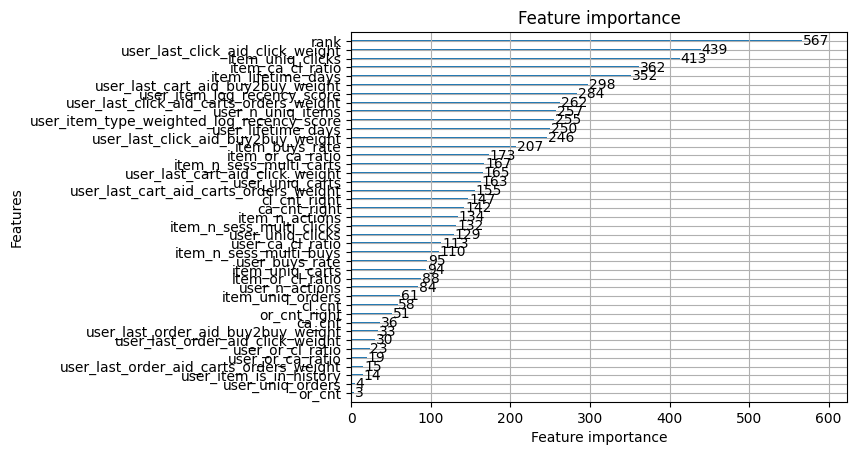

In [145]:
lgb.plot_importance(gbm_ranking)

### Metrics

In [196]:
scores = (
    df_valid_preds
    .select([
        pl.col("scores_fold0"),
        pl.col("scores_fold1"),
        pl.col("scores_fold2"), 
        pl.col("scores_fold3"), 
        pl.col("scores_fold4"),
    ]).mean(axis=1)
)

df_valid_preds_sorted = (
    df_valid_preds
    .with_column(scores.alias("score"))
    .select(["session", "aid", "score"])
    .sort("score", reverse=True)
    .groupby("session")
    .agg([
        pl.list("aid"),
        pl.list("score"),
    ])
)

In [197]:
df_valid_preds_sorted

session,aid,score
i64,list[i64],list[f64]
11889792,"[634452, 1043508, ... 447854]","[null, null, ... null]"
11635712,"[634452, 1043508, ... 1460571]","[null, null, ... null]"
12507264,"[634452, 1043508, ... 1289387]","[null, null, ... null]"
11607232,"[634452, 1043508, ... 1764269]","[null, null, ... null]"
11276992,"[634452, 1043508, ... 1088592]","[null, null, ... null]"
11111168,"[634452, 1043508, ... 485847]","[null, null, ... null]"
11879680,"[634452, 1043508, ... 204078]","[null, null, ... null]"
12685696,"[1496951, 662041, ... 660655]","[2.696228, 0.413933, ... -6.667422]"
12332928,"[634452, 1043508, ... 1113901]","[null, null, ... null]"


In [198]:
# stage 2 valid carts reranked - recall@20 optimized
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["carts"]
topk = 20

for row in tqdm(df_valid_preds_sorted.rows()):
    session_id = row[0]
    rec_items = row[1][:topk]
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels]
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

100%|██████████| 1303355/1303355 [00:04<00:00, 268139.20it/s]


In [199]:
# carts, recall@20 optimized, full valid
df_submission_stage_2_valid_carts_reranked = pl.DataFrame(submission_dict)
df_submission_stage_2_valid_reranked = (
    df_submission_valid
    .join(df_submission_stage_2_valid_carts_reranked, on="session_type", how="left")
    .with_columns([
        (
            pl.when(pl.col("labels_right").is_null())
            .then(pl.col("labels"))
            .otherwise(pl.col("labels_right"))
        ).alias("labels_final")
    ])
    .select(["session_type", "labels_final"])
    .rename({"labels_final": "labels"})
)

In [200]:
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_reranked, topk=20)

validation score: 0.5607868195327335
recall per type: type
carts    0.4114
clicks   0.5155
orders   0.6430
dtype: float64


In [201]:
# carts, no reranking, only valid with targets
calc_valid_score(
    (
        df_submission_valid
        .with_column(
            (
                df_submission_valid["session_type"].str.split("_").arr[0].cast(int)
            ).alias("session")
        )
        .join(df_stage_2_dataset_train.select(["session"]).unique(), on="session")
        .drop("session")
    ), topk=20
)

validation score: 0.5130118837328588
recall per type: type
carts    0.3932
clicks   0.5145
orders   0.5727
dtype: float64


,session_type,labels,session,type,ground_truth,hits,gt_count
0,11107744_clicks,"[1556644, 1637748, 220086, 830498, 263196, 151...",11107744,clicks,[1075085],0,1
1,11107744_carts,"[1556644, 1637748, 220086, 830498, 959553, 813...",11107744,carts,"[165989, 178869, 628545, 1075085]",0,4
2,11107744_orders,"[1556644, 1637748, 220086, 830498, 959553, 497...",11107744,orders,[],0,0
3,11107757_clicks,"[69701, 441214, 1522691, 1777631, 1741724, 135...",11107757,clicks,[],0,0
4,11107757_carts,"[69701, 441214, 1522691, 1777631, 416657, 1285...",11107757,carts,[69701],1,1
...,...,...,...,...,...,...,...
795613,12899676_carts,"[1780088, 182264, 872725, 781589, 888801, 3532...",12899676,carts,[35328],1,1
795614,12899676_orders,"[1780088, 182264, 872725, 888801, 35328, 78158...",12899676,orders,[],0,0
795615,12899732_clicks,"[1126169, 1413049, 894387, 1498443, 830549, 11...",12899732,clicks,[1126169],1,1
795616,12899732_carts,"[1126169, 1413049, 894387, 1498443, 830549, 11...",12899732,carts,[1126169],1,1


In [202]:
# carts, oof preds, only valid with targets - rank + 42 features, no additional targets
calc_valid_score(
    (
        df_submission_stage_2_valid_reranked
        .with_column(
            (
                df_submission_stage_2_valid_reranked["session_type"].str.split("_").arr[0].cast(int)
            ).alias("session")
        )
        .join(df_stage_2_dataset_train.select(["session"]).unique(), on="session")
        .drop("session")
    ), topk=20
)

validation score: 0.5184589655568128
recall per type: type
carts    0.4114
clicks   0.5145
orders   0.5727
dtype: float64


,session_type,labels,session,type,ground_truth,hits,gt_count
0,11107744_clicks,"[1556644, 1637748, 220086, 830498, 263196, 151...",11107744,clicks,[1075085],0,1
1,11107744_carts,"[1556644, 220086, 1637748, 959553, 830498, 813...",11107744,carts,"[165989, 178869, 628545, 1075085]",0,4
2,11107744_orders,"[1556644, 1637748, 220086, 830498, 959553, 497...",11107744,orders,[],0,0
3,11107757_clicks,"[69701, 441214, 1522691, 1777631, 1741724, 135...",11107757,clicks,[],0,0
4,11107757_carts,"[69701, 441214, 1522691, 721908, 1777631, 4166...",11107757,carts,[69701],1,1
...,...,...,...,...,...,...,...
795613,12899676_carts,"[1780088, 182264, 890337, 822558, 872725, 8888...",12899676,carts,[35328],1,1
795614,12899676_orders,"[1780088, 182264, 872725, 888801, 35328, 78158...",12899676,orders,[],0,0
795615,12899732_clicks,"[1126169, 1413049, 894387, 1498443, 830549, 11...",12899732,clicks,[1126169],1,1
795616,12899732_carts,"[1126169, 1413049, 894387, 830549, 1194834, 12...",12899732,carts,[1126169],1,1


In [105]:
# only oof preds, only valid with targets - 100+ features, ADDED TARGET THAT WERE NOT IN CANDIDATES (ERROR!)
calc_valid_score(
    (
        df_submission_stage_2_valid_reranked
        .with_column(
            (
                df_submission_stage_2_valid_reranked["session_type"].str.split("_").arr[0].cast(int)
            ).alias("session")
        )
        .join(df_stage_2_dataset_train.select(["session"]).unique(), on="session")
        .drop("session")
    ), topk=20
)

validation score: 0.5030649379701534
recall per type: type
carts    0.3601
clicks   0.5145
orders   0.5727
dtype: float64


,session_type,labels,session,type,ground_truth,hits,gt_count
0,11107744_clicks,"[1556644, 1637748, 220086, 830498, 263196, 151...",11107744,clicks,[1075085],0,1
1,11107744_carts,"[1556644, 1637748, 220086, 559592, 626690, 171...",11107744,carts,"[165989, 178869, 628545, 1075085]",0,4
2,11107744_orders,"[1556644, 1637748, 220086, 830498, 959553, 497...",11107744,orders,[],0,0
3,11107757_clicks,"[69701, 441214, 1522691, 1777631, 1741724, 135...",11107757,clicks,[],0,0
4,11107757_carts,"[69701, 441214, 117058, 1073807, 1560441, 1333...",11107757,carts,[69701],1,1
...,...,...,...,...,...,...,...
795613,12899676_carts,"[1780088, 892871, 1719943, 890337, 822558, 399...",12899676,carts,[35328],1,1
795614,12899676_orders,"[1780088, 182264, 872725, 888801, 35328, 78158...",12899676,orders,[],0,0
795615,12899732_clicks,"[1126169, 1413049, 894387, 1498443, 830549, 11...",12899732,clicks,[1126169],1,1
795616,12899732_carts,"[1126169, 1669900, 1634780, 1582485, 1663535, ...",12899732,carts,[1126169],1,1


In [147]:
# only oof preds, only valid with targets - 29 features, ADDED TARGET THAT WERE NOT IN CANDIDATES (ERROR!)
calc_valid_score(
    (
        df_submission_stage_2_valid_reranked
        .with_column(
            (
                df_submission_stage_2_valid_reranked["session_type"].str.split("_").arr[0].cast(int)
            ).alias("session")
        )
        .join(df_stage_2_dataset_train.select(["session"]).unique(), on="session")
        .drop("session")
    ), topk=20
)

validation score: 0.5096537763158802
recall per type: type
carts    0.3820
clicks   0.5145
orders   0.5727
dtype: float64


,session_type,labels,session,type,ground_truth,hits,gt_count
0,11107744_clicks,"[1556644, 1637748, 220086, 830498, 263196, 151...",11107744,clicks,[1075085],0,1
1,11107744_carts,"[1556644, 220086, 1637748, 626690, 1719062, 12...",11107744,carts,"[165989, 178869, 628545, 1075085]",0,4
2,11107744_orders,"[1556644, 1637748, 220086, 830498, 959553, 497...",11107744,orders,[],0,0
3,11107757_clicks,"[69701, 441214, 1522691, 1777631, 1741724, 135...",11107757,clicks,[],0,0
4,11107757_carts,"[69701, 441214, 1073807, 1560441, 1333426, 117...",11107757,carts,[69701],1,1
...,...,...,...,...,...,...,...
795613,12899676_carts,"[1780088, 890337, 1719943, 892871, 822558, 247...",12899676,carts,[35328],0,1
795614,12899676_orders,"[1780088, 182264, 872725, 888801, 35328, 78158...",12899676,orders,[],0,0
795615,12899732_clicks,"[1126169, 1413049, 894387, 1498443, 830549, 11...",12899732,clicks,[1126169],1,1
795616,12899732_carts,"[1126169, 1669900, 1634780, 1582485, 830549, 1...",12899732,carts,[1126169],1,1


## orders

### prepare target

In [149]:
orders_target = (
    val_df_valid_targets
    .filter(pl.col("type") == "orders")
    .join(df_candidates.select(["session"]).unique(), on="session", how="inner")
    .drop("type")
    .explode("ground_truth")
    .with_column(pl.lit(1).alias("target"))
    .rename({"ground_truth": "aid"})
)

In [160]:
df_stage_2_dataset_train = (
    df_candidates
    .filter(pl.col("type") == "orders")
    .drop("type")
    .explode(["candidates", "rank"])
#     .drop("rank")
    .rename({"candidates": "aid"})
#     .join(carts_target, on=["session", "aid"], how="outer")
    .join(orders_target, on=["session", "aid"], how="left")  # if using rank column as a feature
    .join(orders_target.select(["session"]).unique(), on="session", how="inner")
    .sort("session")
#     .join(
#         (
#             carts_target.join(carts_pred_stage_2_train.select(["session"]).unique(), on="session")
#         ),
#         on=["session", "aid"], 
#         how="outer"
#     )
#     .join(carts_target.select(["session"]).unique(), on="session", how="inner")
    .unique(subset=["session", "aid"], keep="last").fill_null(0)
)

In [161]:
df_stage_2_dataset_train

session,aid,rank,target
i64,i64,i64,i32
11107757,69701,1,1
11107757,441214,2,0
11107757,1522691,3,0
11107757,1777631,4,0
11107757,309323,5,0
11107757,416657,6,0
11107757,1285692,7,0
11107757,721908,8,0
11107757,1704908,9,0


In [162]:
df_stage_2_dataset_train["target"].value_counts()

target,counts
i32,u32
0,13367038
1,200092


### join features

In [163]:
df_stage_2_dataset_train = (
    df_stage_2_dataset_train
    .join(df_user_last_type_actions, on="session", how="left")
    .join(
        carts_orders.rename({"weight": "user_last_click_aid_carts_orders_weight"}),
        left_on=["aid", "last_click_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        buys2buys.rename({"weight": "user_last_click_aid_buy2buy_weight"}),
        left_on=["aid", "last_click_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        clicks.rename({"weight": "user_last_click_aid_click_weight"}),
        left_on=["aid", "last_click_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        carts_orders.rename({"weight": "user_last_cart_aid_carts_orders_weight"}),
        left_on=["aid", "last_cart_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        buys2buys.rename({"weight": "user_last_cart_aid_buy2buy_weight"}),
        left_on=["aid", "last_cart_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        clicks.rename({"weight": "user_last_cart_aid_click_weight"}),
        left_on=["aid", "last_cart_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        carts_orders.rename({"weight": "user_last_order_aid_carts_orders_weight"}),
        left_on=["aid", "last_order_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        buys2buys.rename({"weight": "user_last_order_aid_buy2buy_weight"}),
        left_on=["aid", "last_order_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        clicks.rename({"weight": "user_last_order_aid_click_weight"}),
        left_on=["aid", "last_order_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .drop(["last_click_aid", "last_cart_aid", "last_order_aid"])
    .fill_null(0)
)

In [164]:
df_stage_2_dataset_train = (
    df_stage_2_dataset_train
    .join(df_user_action_stats_features, on="session", how="left")
#     .join(df_user_time_distr_features, on="session", how="left")
    .join(df_item_action_stats_features, on="aid", how="left")
#     .join(df_item_time_distr_features, on="aid", how="left")
    .join(df_item_n_sess_multiple_action, on="aid", how="left")
    .join(df_user_item_history_features, on=["session", "aid"], how="left")
    .sort("session")
    .fill_null(0)
)

In [165]:
df_stage_2_dataset_for_pred = (
    df_candidates
    .filter(pl.col("type") == "orders")
    .drop("type")
    .explode(["candidates", "rank"])
    .drop("rank")
    .rename({"candidates": "aid"})
    .unique()

#     .join(df_user_main_features, on="session", how="left")
#     .join(df_item_main_features, on="aid", how="left")
#     .join(df_item_n_sess_multiple_action, on="aid", how="left")
#     .join(df_interaction_features, on=["session", "aid"], how="left")
#     .sort("session")
)

assert df_stage_2_dataset_for_pred["session"].n_unique() == 1303355

In [166]:
df_stage_2_dataset_train

session,aid,rank,target,user_last_click_aid_carts_orders_weight,user_last_click_aid_buy2buy_weight,user_last_click_aid_click_weight,user_last_cart_aid_carts_orders_weight,user_last_cart_aid_buy2buy_weight,user_last_cart_aid_click_weight,user_last_order_aid_carts_orders_weight,user_last_order_aid_buy2buy_weight,user_last_order_aid_click_weight,user_lifetime_days,user_n_actions,user_n_uniq_items,user_buys_rate,user_uniq_clicks,user_uniq_carts,user_uniq_orders,cl_cnt,ca_cnt,or_cnt,user_ca_cl_ratio,user_or_cl_ratio,user_or_ca_ratio,item_lifetime_days,item_n_actions,item_n_uniq_users,item_buys_rate,item_uniq_clicks,item_uniq_carts,item_uniq_orders,cl_cnt_right,ca_cnt_right,or_cnt_right,item_ca_cl_ratio,item_or_cl_ratio,item_or_ca_ratio,item_n_sess_multi_clicks,item_n_sess_multi_carts,item_n_sess_multi_buys,user_item_log_recency_score,user_item_type_weighted_log_recency_score,user_item_is_in_history
i64,i64,i64,i32,f64,i32,f64,f64,i32,f64,f64,i32,f64,f64,u32,u32,f64,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,u32,u32,f64,u32,u32,u32,u32,u32,u32,f64,f64,f64,u32,u32,u32,f64,f64,i32
11107757,69701,1,1,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,26.755954,422,1,0.042654,299,9,2,406,14,2,0.034483,0.004926,0.142857,63,1,0,1.0,1.0,1
11107757,441214,2,0,8.5,0,39.636885,0.0,0,0.0,0.0,0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.937732,1509,1,0.051027,927,41,14,1446,49,14,0.033887,0.009682,0.285714,254,6,0,0.071773,0.071773,1
11107757,1522691,3,0,19.5,1,83.20263,0.0,0,0.0,0.0,0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.956197,4184,1,0.090822,1965,287,0,3804,380,0,0.099895,0.0,0.0,739,63,0,0.0,0.0,0
11107757,1777631,4,0,23.5,0,61.517635,0.0,0,0.0,0.0,0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.942352,5716,1,0.098146,3018,252,114,5277,317,122,0.060072,0.023119,0.384858,998,42,8,0.0,0.0,0
11107757,309323,5,0,6.5,2,28.645133,0.0,0,0.0,0.0,0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.942598,13402,1,0.08924,7988,570,185,12408,792,202,0.06383,0.01628,0.255051,2146,99,13,0.0,0.0,0
11107757,416657,6,0,4.5,0,18.822306,0.0,0,0.0,0.0,0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.828345,2411,1,0.075902,1162,138,0,2228,183,0,0.082136,0.0,0.0,425,31,0,0.0,0.0,0
11107757,1285692,7,0,4.0,0,19.797053,0.0,0,0.0,0.0,0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.935301,1500,1,0.1,800,81,26,1377,96,27,0.069717,0.019608,0.28125,247,12,1,0.0,0.0,0
11107757,721908,8,0,14.5,1,65.197773,0.0,0,0.0,0.0,0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,26.474204,544,1,0.110294,278,28,7,493,42,9,0.085193,0.018256,0.214286,94,8,2,0.0,0.0,0
11107757,1704908,9,0,9.0,0,46.126277,0.0,0,0.0,0.0,0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.899176,4167,1,0.094072,2245,196,64,3846,250,71,0.065003,0.018461,0.284,741,32,4,0.0,0.0,0


### train

In [167]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
#     'objective': 'binary',
    'objective': 'lambdarank',
    'metric': '"None"',
    'eval_at': 20,
#     'metric': {'auc', 'binary_logloss'},
#     'min_data_in_leaf': 256, 
#     'num_leaves': 63,
    'max_depth': 7,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'device': 'gpu',
    'verbose': -1,
    'num_threads': 40,
}

In [168]:
feature_cols = ["rank"] + df_stage_2_dataset_train.columns[4:]
feature_cols

['rank',
 'user_last_click_aid_carts_orders_weight',
 'user_last_click_aid_buy2buy_weight',
 'user_last_click_aid_click_weight',
 'user_last_cart_aid_carts_orders_weight',
 'user_last_cart_aid_buy2buy_weight',
 'user_last_cart_aid_click_weight',
 'user_last_order_aid_carts_orders_weight',
 'user_last_order_aid_buy2buy_weight',
 'user_last_order_aid_click_weight',
 'user_lifetime_days',
 'user_n_actions',
 'user_n_uniq_items',
 'user_buys_rate',
 'user_uniq_clicks',
 'user_uniq_carts',
 'user_uniq_orders',
 'cl_cnt',
 'ca_cnt',
 'or_cnt',
 'user_ca_cl_ratio',
 'user_or_cl_ratio',
 'user_or_ca_ratio',
 'item_lifetime_days',
 'item_n_actions',
 'item_n_uniq_users',
 'item_buys_rate',
 'item_uniq_clicks',
 'item_uniq_carts',
 'item_uniq_orders',
 'cl_cnt_right',
 'ca_cnt_right',
 'or_cnt_right',
 'item_ca_cl_ratio',
 'item_or_cl_ratio',
 'item_or_ca_ratio',
 'item_n_sess_multi_clicks',
 'item_n_sess_multi_carts',
 'item_n_sess_multi_buys',
 'user_item_log_recency_score',
 'user_item_type_w

In [169]:
skf = GroupKFold(n_splits=5)

df_valid_preds = df_stage_2_dataset_for_pred.select(["session", "aid"]).unique()

for fold, (train_idx, valid_idx) in tqdm(enumerate(
    skf.split(df_stage_2_dataset_train,
              df_stage_2_dataset_train['target'],
              groups=df_stage_2_dataset_train['session'])
)):
    
    X_train = df_stage_2_dataset_train[train_idx][feature_cols].to_pandas()
    y_train = df_stage_2_dataset_train[train_idx]["target"].to_pandas()
    X_valid = df_stage_2_dataset_train[valid_idx][feature_cols].to_pandas()
    y_valid = df_stage_2_dataset_train[valid_idx]["target"].to_pandas()
    
    # create dataset for lightgbm
    groups_len_train = (
        df_stage_2_dataset_train[train_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )
    groups_len_valid = (
        df_stage_2_dataset_train[valid_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )    
    lgb_train = lgb.Dataset(X_train, y_train, group=groups_len_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, group=groups_len_valid, reference=lgb_train)
    
    # train model
    gbm_ranking = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
#         return_cvbooster=True,
        feval=lgb_numba_recall,
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=20)]
    )
    
    # predict scores for remained pred period - to handle leakage
#     X_test = (
#         df_stage_2_dataset_for_pred
#         .join(
#             df_stage_2_dataset_train[train_idx].select(["session", "aid", pl.lit(1).alias("is_train")]),
#             on=["session", "aid"],
#             how="left"
#         )
#         .filter(pl.col("is_train").is_null())
#         .drop("is_train")
#     )
    
#     scores = gbm_ranking.predict(X_test[:, 2:].to_pandas())
    
    scores = gbm_ranking.predict(X_valid)
#     df_valid_preds_fold = (
#         X_test.select(["session", "aid"])
#         .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
#     )
    df_valid_preds_fold = (
        df_stage_2_dataset_train[valid_idx].select(["session", "aid"])
        .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
    )
    df_valid_preds = (
        df_valid_preds.join(df_valid_preds_fold, on=["session", "aid"], how="left")
    )
    
    # add save models
    gbm_ranking.save_model(f"__model__orders_covisit_top200_reranker_rank+44feat_fold{fold}.lgb")

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.93327
[40]	valid_0's numba_recall@20: 0.93684
[60]	valid_0's numba_recall@20: 0.937839
[80]	valid_0's numba_recall@20: 0.938088
[100]	valid_0's numba_recall@20: 0.939012
[120]	valid_0's numba_recall@20: 0.939187
[140]	valid_0's numba_recall@20: 0.939636
[160]	valid_0's numba_recall@20: 0.939886
[180]	valid_0's numba_recall@20: 0.939836
[200]	valid_0's numba_recall@20: 0.939711
[220]	valid_0's numba_recall@20: 0.940285
[240]	valid_0's numba_recall@20: 0.940335
[260]	valid_0's numba_recall@20: 0.940535
[280]	valid_0's numba_recall@20: 0.940535
[300]	valid_0's numba_recall@20: 0.940734
[320]	valid_0's numba_recall@20: 0.940834
[340]	valid_0's numba_recall@20: 0.941009
[360]	valid_0's numba_recall@20: 0.941009
[380]	valid_0's numba_recall@20: 0.941084
[400]	valid_0's numba_recall@20: 0.941084
[420]	valid_0's numba_recall@20: 0.940859
[440]	valid_0's numba_recall@20: 0.940959
[460]	valid_0's numb

1it [01:54, 114.44s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.932033
[40]	valid_0's numba_recall@20: 0.934876
[60]	valid_0's numba_recall@20: 0.936049
[80]	valid_0's numba_recall@20: 0.936947
[100]	valid_0's numba_recall@20: 0.937445
[120]	valid_0's numba_recall@20: 0.937545
[140]	valid_0's numba_recall@20: 0.938144
[160]	valid_0's numba_recall@20: 0.938293
[180]	valid_0's numba_recall@20: 0.938144
[200]	valid_0's numba_recall@20: 0.938044
[220]	valid_0's numba_recall@20: 0.938194
[240]	valid_0's numba_recall@20: 0.938318
[260]	valid_0's numba_recall@20: 0.938518
[280]	valid_0's numba_recall@20: 0.938643
[300]	valid_0's numba_recall@20: 0.938568
[320]	valid_0's numba_recall@20: 0.938593
[340]	valid_0's numba_recall@20: 0.938693
[360]	valid_0's numba_recall@20: 0.938418
[380]	valid_0's numba_recall@20: 0.938742
[400]	valid_0's numba_recall@20: 0.938992
[420]	valid_0's numba_recall@20: 0.939117
[440]	valid_0's numba_recall@20: 0.939017
[460]	valid_0's nu

2it [04:02, 122.17s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.93407
[40]	valid_0's numba_recall@20: 0.937602
[60]	valid_0's numba_recall@20: 0.939205
[80]	valid_0's numba_recall@20: 0.939681
[100]	valid_0's numba_recall@20: 0.939931
[120]	valid_0's numba_recall@20: 0.940182
[140]	valid_0's numba_recall@20: 0.940633
[160]	valid_0's numba_recall@20: 0.940908
[180]	valid_0's numba_recall@20: 0.940908
[200]	valid_0's numba_recall@20: 0.940933
[220]	valid_0's numba_recall@20: 0.940858
[240]	valid_0's numba_recall@20: 0.940958
[260]	valid_0's numba_recall@20: 0.941084
[280]	valid_0's numba_recall@20: 0.941159
[300]	valid_0's numba_recall@20: 0.941259
[320]	valid_0's numba_recall@20: 0.941359
[340]	valid_0's numba_recall@20: 0.941434
[360]	valid_0's numba_recall@20: 0.941685
[380]	valid_0's numba_recall@20: 0.941635
[400]	valid_0's numba_recall@20: 0.94181
[420]	valid_0's numba_recall@20: 0.94181
[440]	valid_0's numba_recall@20: 0.94186
[460]	valid_0's numba_

3it [05:46, 114.23s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.933704
[40]	valid_0's numba_recall@20: 0.937497
[60]	valid_0's numba_recall@20: 0.938245
[80]	valid_0's numba_recall@20: 0.938719
[100]	valid_0's numba_recall@20: 0.938869
[120]	valid_0's numba_recall@20: 0.939194
[140]	valid_0's numba_recall@20: 0.939668
[160]	valid_0's numba_recall@20: 0.939767
[180]	valid_0's numba_recall@20: 0.939693
[200]	valid_0's numba_recall@20: 0.940067
[220]	valid_0's numba_recall@20: 0.940067
[240]	valid_0's numba_recall@20: 0.939967
[260]	valid_0's numba_recall@20: 0.939992
[280]	valid_0's numba_recall@20: 0.939892
[300]	valid_0's numba_recall@20: 0.940266
[320]	valid_0's numba_recall@20: 0.940491
[340]	valid_0's numba_recall@20: 0.940566
[360]	valid_0's numba_recall@20: 0.940491
[380]	valid_0's numba_recall@20: 0.940466
[400]	valid_0's numba_recall@20: 0.940516
[420]	valid_0's numba_recall@20: 0.940416
[440]	valid_0's numba_recall@20: 0.940516
[460]	valid_0's nu

4it [07:45, 116.14s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.931381
[40]	valid_0's numba_recall@20: 0.934844
[60]	valid_0's numba_recall@20: 0.936349
[80]	valid_0's numba_recall@20: 0.936474
[100]	valid_0's numba_recall@20: 0.936826
[120]	valid_0's numba_recall@20: 0.937202
[140]	valid_0's numba_recall@20: 0.937378
[160]	valid_0's numba_recall@20: 0.937478
[180]	valid_0's numba_recall@20: 0.937478
[200]	valid_0's numba_recall@20: 0.937804
[220]	valid_0's numba_recall@20: 0.93803
[240]	valid_0's numba_recall@20: 0.937955
[260]	valid_0's numba_recall@20: 0.938005
[280]	valid_0's numba_recall@20: 0.937829
[300]	valid_0's numba_recall@20: 0.937829
Early stopping, best iteration is:
[211]	valid_0's numba_recall@20: 0.938105


5it [08:47, 105.41s/it]


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

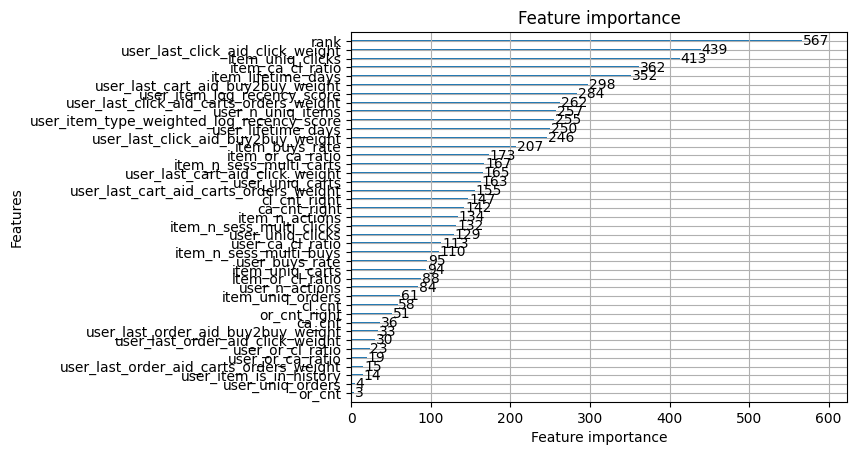

In [145]:
lgb.plot_importance(gbm_ranking)

### Metrics

In [170]:
scores = (
    df_valid_preds
    .select([
        pl.col("scores_fold0"),
        pl.col("scores_fold1"),
        pl.col("scores_fold2"), 
        pl.col("scores_fold3"), 
        pl.col("scores_fold4"),
    ]).mean(axis=1)
)

df_valid_preds_sorted = (
    df_valid_preds
    .with_column(scores.alias("score"))
    .select(["session", "aid", "score"])
    .sort("score", reverse=True)
    .groupby("session")
    .agg([
        pl.list("aid"),
        pl.list("score"),
    ])
)

In [171]:
df_valid_preds_sorted

session,aid,score
i64,list[i64],list[f64]
12675584,"[1462420, 530377, ... 945572]","[null, null, ... null]"
11469504,"[1462420, 530377, ... 1515266]","[null, null, ... null]"
12880960,"[1462420, 530377, ... 878972]","[null, null, ... null]"
12424192,"[1462420, 530377, ... 1376436]","[null, null, ... null]"
11115200,"[1462420, 530377, ... 358088]","[null, null, ... null]"
12771840,"[1462420, 530377, ... 755668]","[null, null, ... null]"
12889600,"[1462420, 530377, ... 1745812]","[null, null, ... null]"
12393216,"[1505122, 1697519, ... 130016]","[null, null, ... null]"
11462592,"[1462420, 530377, ... 464835]","[null, null, ... null]"


In [175]:
# stage 2 valid orders reranked - recall@20 optimized
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["orders"]
topk = 20

for row in tqdm(df_valid_preds_sorted.rows()):
    session_id = row[0]
    rec_items = row[1][:topk]
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels]
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

100%|██████████| 1303355/1303355 [00:04<00:00, 269756.21it/s]


In [176]:
# orders, recall@20 optimized, full valid
df_submission_stage_2_valid_orders_reranked = pl.DataFrame(submission_dict)
df_submission_stage_2_valid_reranked = (
    df_submission_valid
    .join(df_submission_stage_2_valid_orders_reranked, on="session_type", how="left")
    .with_columns([
        (
            pl.when(pl.col("labels_right").is_null())
            .then(pl.col("labels"))
            .otherwise(pl.col("labels_right"))
        ).alias("labels_final")
    ])
    .select(["session_type", "labels_final"])
    .rename({"labels_final": "labels"})
)

In [90]:
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_reranked, topk=20)

validation score: 0.5352322010735644
recall per type: type
carts    0.3262
clicks   0.5155
orders   0.6430
dtype: float64


In [178]:
# orders, no reranking, only valid with targets
calc_valid_score(
    (
        df_submission_valid
        .with_column(
            (
                df_submission_valid["session_type"].str.split("_").arr[0].cast(int)
            ).alias("session")
        )
        .join(df_stage_2_dataset_train.select(["session"]).unique(), on="session")
        .drop("session")
    ), topk=20
)

validation score: 0.5539901269174999
recall per type: type
carts    0.3797
clicks   0.5426
orders   0.6430
dtype: float64


,session_type,labels,session,type,ground_truth,hits,gt_count
0,11107757_clicks,"[69701, 441214, 1522691, 1777631, 1741724, 135...",11107757,clicks,[],0,0
1,11107757_carts,"[69701, 441214, 1522691, 1777631, 416657, 1285...",11107757,carts,[69701],1,1
2,11107757_orders,"[69701, 441214, 1522691, 1777631, 309323, 4166...",11107757,orders,[69701],1,1
3,11107761_clicks,"[1077259, 1287701, 1835591, 801055, 1158840, 2...",11107761,clicks,[1789315],0,1
4,11107761_carts,"[1077259, 1287701, 1835591, 1158840, 217117, 8...",11107761,carts,"[217117, 240567, 559821, 950341, 1077259, 1287...",7,9
...,...,...,...,...,...,...,...
403993,12899373_carts,"[1766353, 995962, 487949, 461938, 117765, 1123...",12899373,carts,[1844832],1,1
403994,12899373_orders,"[1766353, 995962, 487949, 461938, 516917, 1763...",12899373,orders,[1766353],1,1
403995,12899525_clicks,"[1599360, 1488793, 127479, 996393, 1523205, 40...",12899525,clicks,[],0,0
403996,12899525_carts,"[1599360, 1488793, 127479, 996393, 405179, 152...",12899525,carts,[],0,0


In [179]:
# orders, oof preds, only valid with targets - rank + 42 features, no additional targets
calc_valid_score(
    (
        df_submission_stage_2_valid_reranked
        .with_column(
            (
                df_submission_stage_2_valid_reranked["session_type"].str.split("_").arr[0].cast(int)
            ).alias("session")
        )
        .join(df_stage_2_dataset_train.select(["session"]).unique(), on="session")
        .drop("session")
    ), topk=20
)

validation score: 0.5596349524940547
recall per type: type
carts    0.3797
clicks   0.5426
orders   0.6525
dtype: float64


,session_type,labels,session,type,ground_truth,hits,gt_count
0,11107757_clicks,"[69701, 441214, 1522691, 1777631, 1741724, 135...",11107757,clicks,[],0,0
1,11107757_carts,"[69701, 441214, 1522691, 1777631, 416657, 1285...",11107757,carts,[69701],1,1
2,11107757_orders,"[69701, 441214, 1777631, 721908, 309323, 12856...",11107757,orders,[69701],1,1
3,11107761_clicks,"[1077259, 1287701, 1835591, 801055, 1158840, 2...",11107761,clicks,[1789315],0,1
4,11107761_carts,"[1077259, 1287701, 1835591, 1158840, 217117, 8...",11107761,carts,"[217117, 240567, 559821, 950341, 1077259, 1287...",7,9
...,...,...,...,...,...,...,...
403993,12899373_carts,"[1766353, 995962, 487949, 461938, 117765, 1123...",12899373,carts,[1844832],1,1
403994,12899373_orders,"[1766353, 487949, 516917, 1821135, 461938, 995...",12899373,orders,[1766353],1,1
403995,12899525_clicks,"[1599360, 1488793, 127479, 996393, 1523205, 40...",12899525,clicks,[],0,0
403996,12899525_carts,"[1599360, 1488793, 127479, 996393, 405179, 152...",12899525,carts,[],0,0


In [181]:
df_submission_stage_2_valid_reranked_all = (
    df_submission_valid
    .join(
        pl.concat([
            df_submission_stage_2_valid_carts_reranked,
            df_submission_stage_2_valid_orders_reranked
        ]), 
        on="session_type", how="left"
    )
    .with_columns([
        (
            pl.when(pl.col("labels_right").is_null())
            .then(pl.col("labels"))
            .otherwise(pl.col("labels_right"))
        ).alias("labels_final")
    ])
    .select(["session_type", "labels_final"])
    .rename({"labels_final": "labels"})
)

In [183]:
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_reranked_all, topk=20)

validation score: 0.5664316451092883
recall per type: type
carts    0.4114
clicks   0.5155
orders   0.6525
dtype: float64
